In [32]:
import polars as pl
import wandb
import seaborn as sns
from typing import Literal

### Fetch runs from W&B

In [50]:
def get_runs(api: wandb.Api, dataset: Literal['genomic_benchmark', 'nucleotide_transformer']):
    runs = api.runs("mcvicker-lab/dna-lm", filters={
        'config.dataset._name_': dataset,
        'config.wandb.group': {'$regex': r'Checkpoints'}
    })
    run_name = []
    val_acc = []
    task = []
    ckpt = []
    group = []
    for run in runs:
        if run.state != 'finished':
            continue
        run_name.append(run.name)
        val_acc.append(run.summary.get('val/accuracy', None))
        task.append(run.config['dataset']['dataset_name'])
        ckpt.append(run.config['train']['pretrained_model_path'])
        group.append(run.config['wandb']['group'])
    df = (
        pl.DataFrame({
            'run_name': run_name,
            'val/accuracy': val_acc,
            'task': task,
            'ckpt': ckpt,
            'group': group
        })
        .with_columns(
            pl.col('ckpt').str.split('/').list.get(-2),
            model=pl.col('group').str.extract(r'\w+ (1\.4|7)M', 0),
        )
        .with_columns(
            version=pl.col('ckpt').str.extract(r'\d+$', 0).cast(pl.Int32),
        )
        .drop('group')
    )
    return df

In [20]:
api = wandb.Api()

In [51]:
gen_bench = get_runs(api, 'genomic_benchmark')
gen_bench.head()

run_name,val/accuracy,task,ckpt,model,version
str,f64,str,str,str,i32
"""tough-grass-55…",0.790026,"""human_ocr_ense…","""model-l968ycve…","""Cactus 1.4M""",9
"""dashing-lion-5…",0.960288,"""human_nontata_…","""model-l968ycve…","""Cactus 1.4M""",9
"""pleasant-wood-…",0.855873,"""human_ensembl_…","""model-l968ycve…","""Cactus 1.4M""",9
"""celestial-soun…",0.842459,"""human_enhancer…","""model-l968ycve…","""Cactus 1.4M""",9
"""pretty-darknes…",0.700949,"""human_enhancer…","""model-l968ycve…","""Cactus 1.4M""",9


In [22]:
gen_bench.height, gen_bench.select('task', 'ckpt').n_unique()

(128, 128)

In [52]:
nuc_trans = get_runs(api, 'nucleotide_transformer')
nuc_trans.head()

run_name,val/accuracy,task,ckpt,model,version
str,f64,str,str,str,i32
"""sandy-music-57…",0.953182,"""splice_sites_d…","""model-l968ycve…","""Cactus 1.4M""",9
"""clean-bird-573…",0.955882,"""splice_sites_a…","""model-l968ycve…","""Cactus 1.4M""",9
"""worldly-jazz-5…",0.951923,"""promoter_tata""","""model-l968ycve…","""Cactus 1.4M""",9
"""dainty-dust-57…",0.960407,"""promoter_non_t…","""model-l968ycve…","""Cactus 1.4M""",9
"""peachy-surf-57…",0.961655,"""promoter_all""","""model-l968ycve…","""Cactus 1.4M""",9


In [24]:
nuc_trans.height, nuc_trans.select('task', 'ckpt').n_unique()

(240, 240)

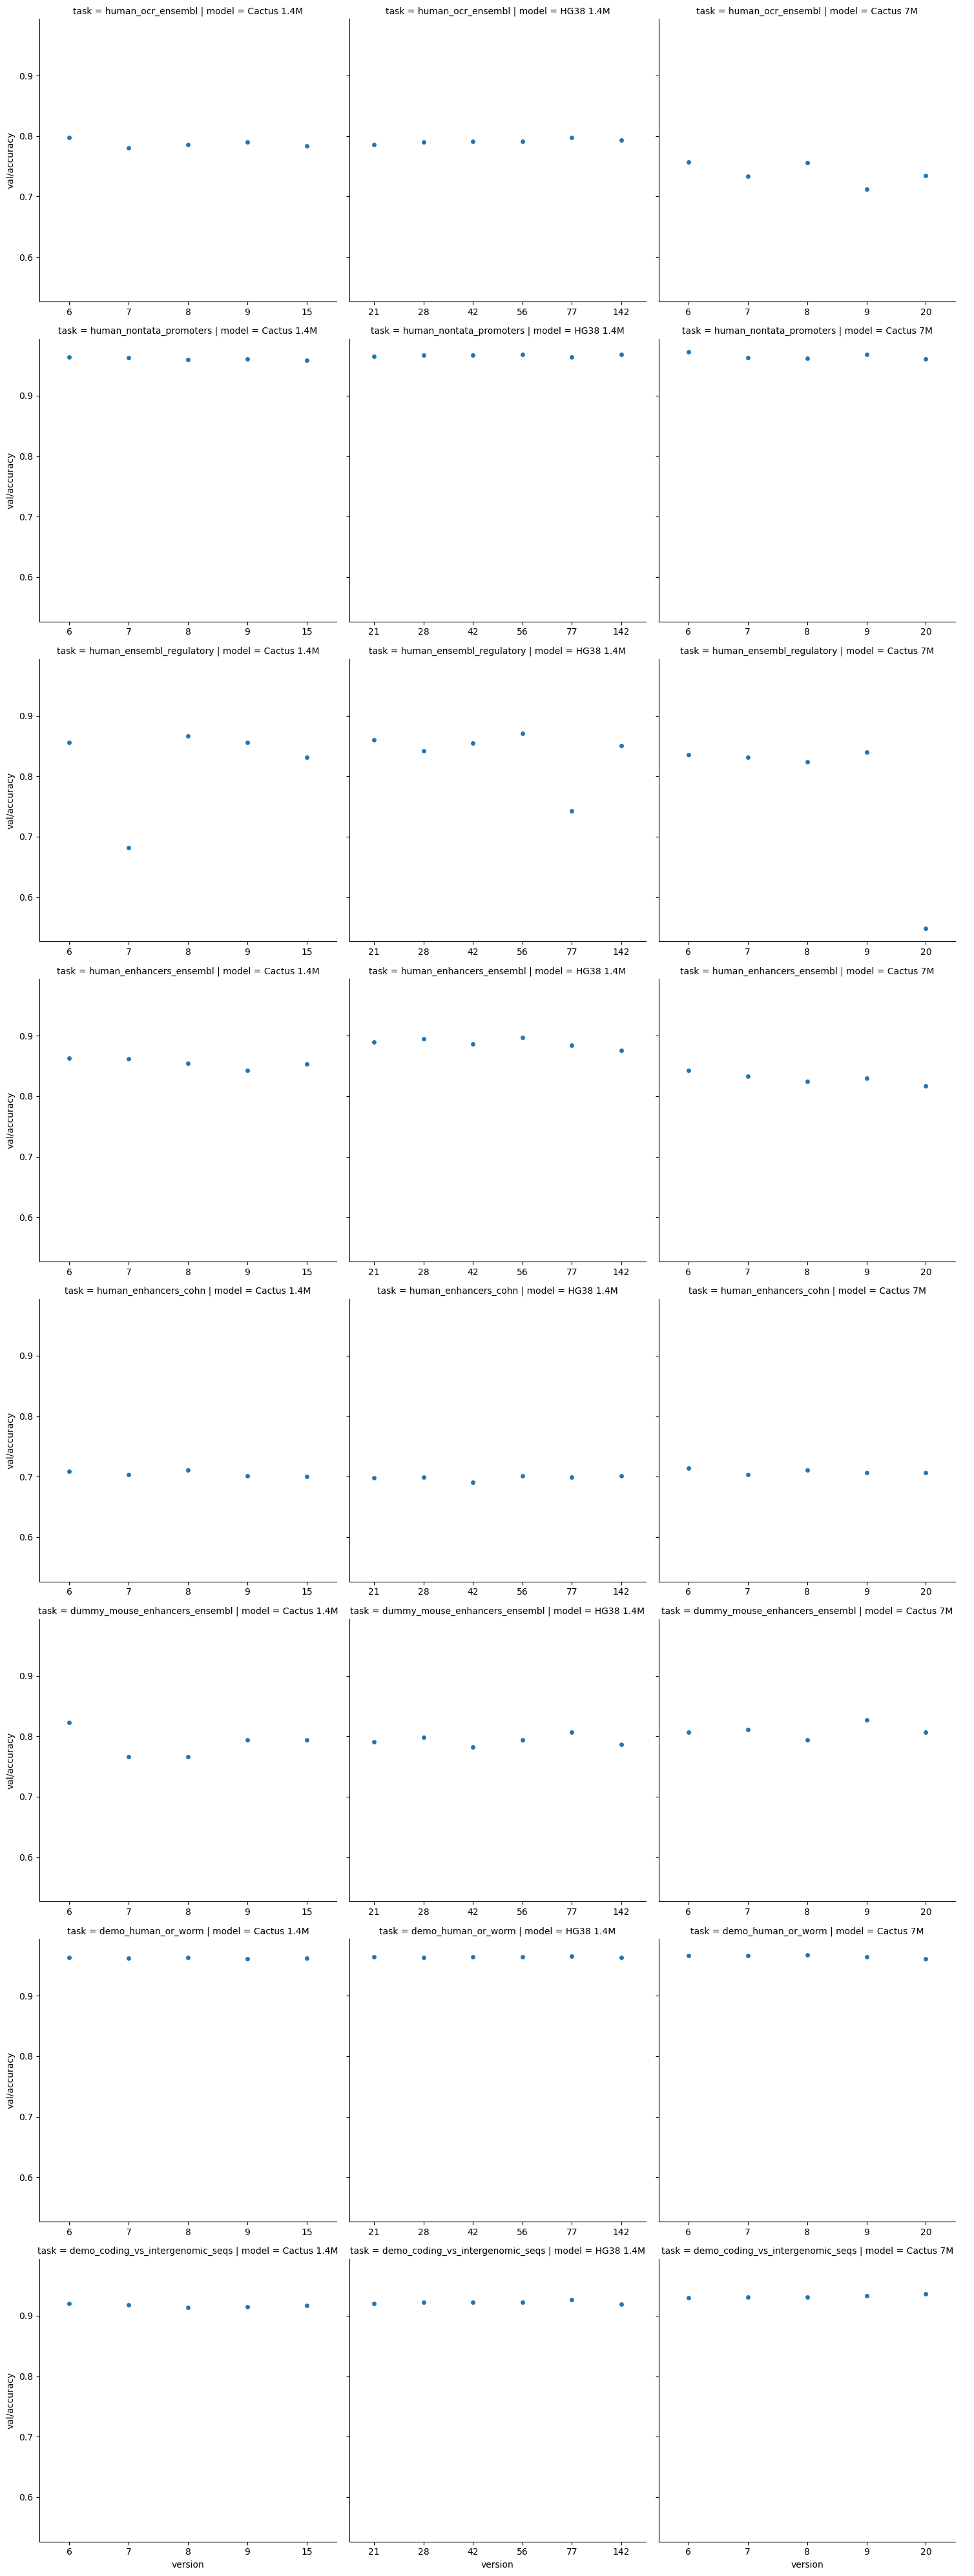

In [53]:
sns.catplot(gen_bench, x='version', y='val/accuracy', row='task', col='model', sharex=False)

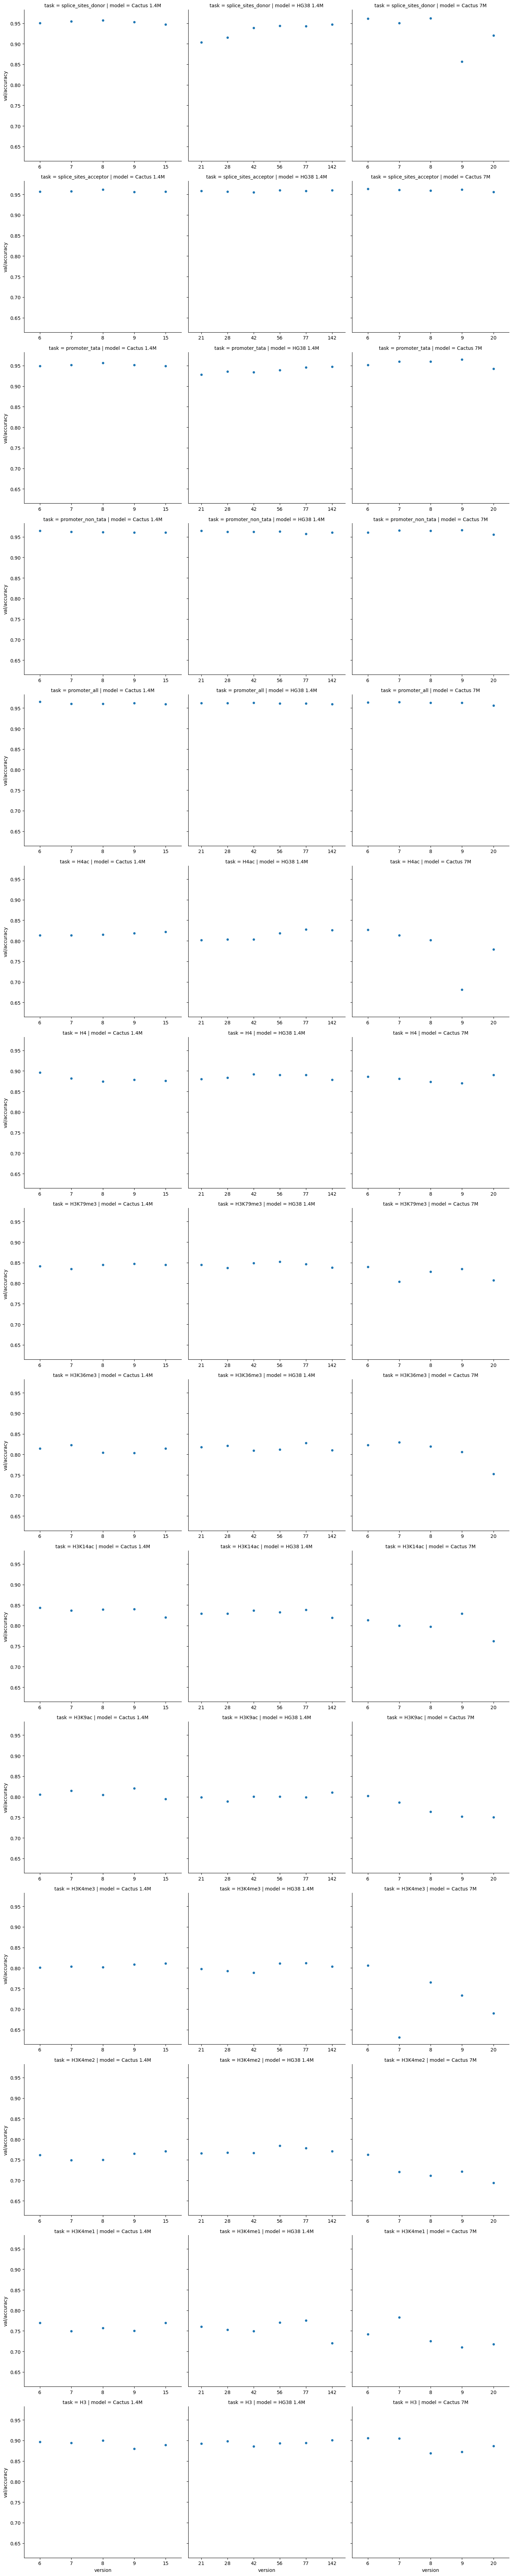

In [54]:
sns.catplot(nuc_trans, x='version', y='val/accuracy', row='task', col='model', sharex=False)

### Annotate model checkpoints

1. Get last two terms of file path, for example:

    From `/home/ubuntu/HyenaDNA_collab/hyena-dna-repo/mamba_checkpoints/artifacts/model-l968ycve:v9/model.ckpt`

    Extract `model-l968ycve:v9`
2. Get # tokens seen and perplexity of model at that checkpoint


In [80]:
artifact = api.artifact(f"mcvicker-lab/dna-lm/{gen_bench['ckpt'][0]}", type="model")
artifact.metadata

{'score': None,
 'ModelCheckpoint': {'mode': 'min',
  'monitor': 'test/loss',
  'save_last': True,
  'save_top_k': -1,
  'save_weights_only': False,
  '_every_n_train_steps': 10000},
 'original_filename': 'last.ckpt'}